In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Find the cloud depth

i.e. the 'z' value for which $\tau = 1$ (starting from the outside)

In [2]:
from scipy.integrate import trapz
from scipy.interpolate import interp1d

In [3]:
from astropy.table import Table

In [4]:
lat, lon  = 0, 0
zfile = 'static_weather_results/HATP_7b_Phi-180.0Theta0.0/out3_chem1.dat'
extfile = 'static_weather_results/HATP_7b_Phi-180.0Theta0.0/out3_extinction.dat'
thermofile = 'static_weather_results/HATP_7b_Phi-180.0Theta0.0/out3_thermo.dat'

In [5]:
z = np.array(Table.read(zfile, format='ascii', header_start=2, data_start=3)['z']) # cm
rho = np.array(Table.read(thermofile, format='ascii', header_start=2, data_start=3)['rho']) # g cm^-3

[]

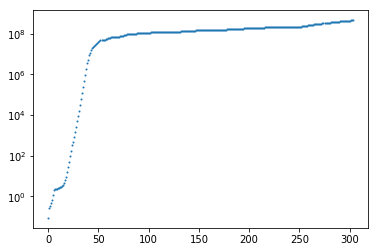

In [6]:
plt.plot(z, 'o', markersize=1)
plt.semilogy()

In [7]:
junk  = np.loadtxt(extfile, skiprows=4)
p = junk[:,0]
kappa = junk[:,1:] # cm^2 g^-1 (cross section per unit atmospheric mass) 
# typical dust-to-gas ratio is 1.e-4
rho2d = np.tile(rho, (len(kappa[0,:]), 1)).T
dtau_dz = kappa * rho2d

In [8]:
# get the wavelengths
def get_wavel(filename):
    f = open(filename, 'r')
    _ = f.readline()
    _ = f.readline()
    wavel_text = f.readline().split()
    return np.array([np.float(w) for w in wavel_text])

In [9]:
wavel = get_wavel(extfile)

** What does the extinction look like as a function of z? **

(1e-10, 10.0)

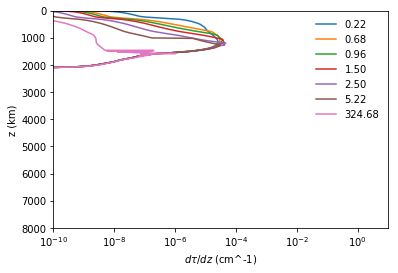

In [10]:
for i in range(len(wavel))[::5]:
    plt.plot(dtau_dz[:,i], z * 1.e-5, label='{:.2f}'.format(wavel[i]))
plt.legend(loc='upper right', frameon=False)
plt.semilogx()
plt.ylabel('z (km)')
plt.xlabel(r'$d\tau/dz$ (cm^-1)')
plt.ylim(8000, 0)
plt.xlim(1.e-10, 10.0)

** Write a function to calculate the cumulative integral at every wavelength **

In [11]:
def cumulative_integral(z, ext):
    z2d = np.tile(z, (len(ext[0,:]), 1)).T
    result = np.zeros(shape=(len(z), len(ext[0])))
    for i in np.arange(1, len(z), dtype=int):
        result[i,:] = trapz(ext[:i+1,:], z2d[:i+1,:], axis=0)
    return result

In [12]:
tau = cumulative_integral(z, dtau_dz)

(0.001, 10000.0)

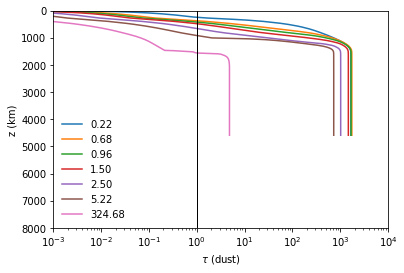

In [13]:
for i in range(len(wavel))[::5]:
    plt.plot(tau[:,i], z*1.e-5, label='{:.2f}'.format(wavel[i]))
plt.legend(loc='lower left', frameon=False)
plt.semilogx()
plt.ylabel('z (km)')
plt.xlabel(r'$\tau$ (dust)')
plt.ylim(8000, 0)
plt.axvline(1.0, color='k', lw=1)
plt.xlim(1.e-3, 1.e4)

(0.01, 100)

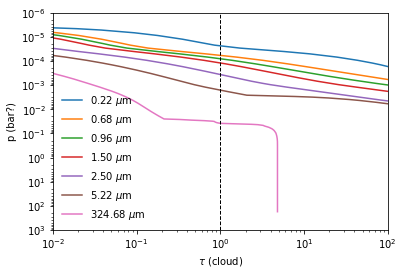

In [14]:
for i in range(len(wavel))[::5]:
    plt.plot(tau[:,i], p * 1.e-6, label='{:.2f} $\mu$m'.format(wavel[i]))
plt.legend(loc='lower left', frameon=False)
plt.loglog()
plt.xlabel(r'$\tau$ (cloud)')
plt.ylabel(r'p (bar?)')
plt.ylim(1.e3, 1.e-6)
plt.axvline(1.0, color='k', lw=1, ls='--')
plt.xlim(0.01, 100)

## Find the point where $\tau = 1$

In [15]:
from maplib import read_file

In [16]:
def calc_cloud_depth(z, integrand, tau=1.0, p_val=True):
    x = z
    if p_val:
        thermo = read_file(thermofile)
        x = thermo['p'] * 1.e-6 # bar
    
    result = []
    for i in range(len(integrand[0])):
        tau_interp = interp1d(integrand[:,i], x, fill_value=(x[0], x[-1]), bounds_error=False)
        result.append(tau_interp(tau))
    return np.array(result) # cm

In [17]:
dep = calc_cloud_depth(z, tau, p_val=False) * 1.e-5 # km

(2000, 0)

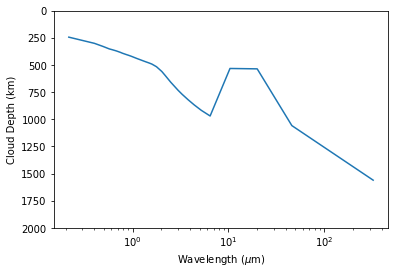

In [18]:
plt.plot(wavel, dep)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Cloud Depth (km)')
plt.semilogx()
plt.ylim(2000, 0)

(1000.0, 1e-06)

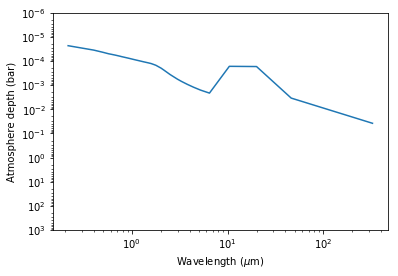

In [19]:
dep2 = calc_cloud_depth(z, tau, p_val=True) # bar
plt.plot(wavel, dep2)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Atmosphere depth (bar)')
plt.loglog()
plt.ylim(1.e3, 1.e-6)

## Test Python script

In [20]:
from maplib import cloud_depth

In [21]:
w, d = cloud_depth('-180.0', '0.0', p_val=False) # returns wavelength (um), depth (cm)

(2000, 0)

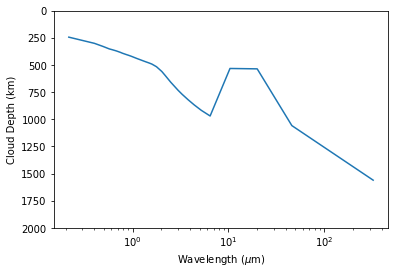

In [22]:
plt.plot(w, d*1.e-5)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Cloud Depth (km)')
plt.semilogx()
plt.ylim(2000, 0)

In [23]:
w, p = cloud_depth('-180.0', '0.0', p_val=True) # returns wavelength (um), depth (dyne/cm^2)

(1000.0, 1e-06)

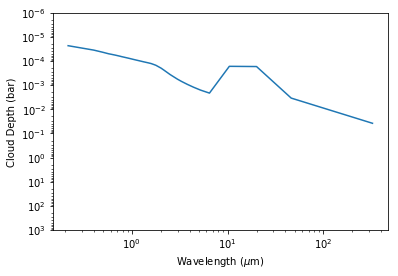

In [24]:
plt.plot(w, p*1.e-6)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Cloud Depth (bar)')
plt.loglog()
plt.ylim(1.e3, 1.e-6)